In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

from model import ConvolutionalNeuralNetwork
from tictactoeenv import TicTacToeEnv

BASE_DIR = os.getcwd()
MODELS_DIR = os.path.join(BASE_DIR, "trained_models")
MODEL_X_PATH = os.path.join(MODELS_DIR, "trained_model_X.pth")
MODEL_O_PATH = os.path.join(MODELS_DIR, "trained_model_O.pth")

MODEL_X_PATH, MODEL_O_PATH


('d:\\Python\\my_side_projects\\TactiQ\\dqn_version\\trained_models\\trained_model_X.pth',
 'd:\\Python\\my_side_projects\\TactiQ\\dqn_version\\trained_models\\trained_model_O.pth')

In [2]:
class EvalAgent:
    """
    Egyszerű értékelő ügynök, aki csak greedy módon választ akciót
    egy betanított ConvolutionalNeuralNetwork segítségével.
    Nincs tanulás, nincs epsilon.
    """

    def __init__(self, model_path: str, player_mark: int) -> None:
        self.player_mark = player_mark  # +1 = X, -1 = O
        self.model = ConvolutionalNeuralNetwork()
        self.model.load_state_dict(
            torch.load(model_path, map_location=torch.device("cpu"))
        )
        self.model.eval()

    def select_action(self, state: np.ndarray) -> int | None:
        state = np.array(state, dtype=np.float32)
        flat = state.flatten()
        valid = [i for i, v in enumerate(flat) if v == 0]

        if not valid:
            return None

        state_t = torch.from_numpy(state).float().unsqueeze(0)
        with torch.no_grad():
            q_vals = self.model(state_t)[0]

        # Érvénytelen lépések maszkolása
        mask = torch.full_like(q_vals, float("-inf"))
        mask[valid] = q_vals[valid]
        action = int(torch.argmax(mask).item())
        return action


def select_random_action(state: np.ndarray) -> int | None:
    flat = state.flatten()
    valid = [i for i, v in enumerate(flat) if v == 0]
    if not valid:
        return None
    return int(np.random.choice(valid))


def play_single_episode(
    env: TicTacToeEnv,
    agent_x: EvalAgent | None = None,
    agent_o: EvalAgent | None = None,
    random_x: bool = False,
    random_o: bool = False,
) -> tuple[str, float, float]:
    """
    Lejátszik egy epizódot a megadott beállításokkal.

    Visszatér:
        winner: "X", "O" vagy "draw"
        episode_reward_x: X teljes epizód-jutalma
        episode_reward_o: O teljes epizód-jutalma
    """
    env.reset()
    current_player = 1  # X kezd
    episode_reward_x = 0.0
    episode_reward_o = 0.0

    winner = "draw"

    max_steps = env.size * env.size + 10
    step_count = 0

    while True:
        step_count += 1
        state = env.get_board_actual_state()

        if current_player == 1:
            if random_x:
                action = select_random_action(state)
            else:
                action = agent_x.select_action(state)
        else:
            if random_o:
                action = select_random_action(state)
            else:
                action = agent_o.select_action(state)

        if action is None:
            # Nincsenek legális lépések → fallback: döntetlen
            winner = "draw"
            break

        reward, done, is_illegal = env.play_step(action, current_player)

        if current_player == 1:
            episode_reward_x += reward
        else:
            episode_reward_o += reward

        if done:
            if reward > 0:
                winner = "X" if current_player == 1 else "O"
            else:
                # env -2-t ad döntetlenre
                winner = "draw"
            break

        if step_count >= max_steps:
            winner = "draw"
            break

        # játékos váltás
        current_player = -current_player

    return winner, episode_reward_x, episode_reward_o


In [3]:
def run_eval_self_play(num_episodes: int = 1000):
    env = TicTacToeEnv()
    agent_x = EvalAgent(MODEL_X_PATH, player_mark=1)
    agent_o = EvalAgent(MODEL_O_PATH, player_mark=-1)

    wins_x = 0
    wins_o = 0
    draws = 0
    rewards_x: list[float] = []
    rewards_o: list[float] = []

    for _ in range(num_episodes):
        winner, ep_rx, ep_ro = play_single_episode(
            env,
            agent_x=agent_x,
            agent_o=agent_o,
            random_x=False,
            random_o=False,
        )
        if winner == "X":
            wins_x += 1
        elif winner == "O":
            wins_o += 1
        else:
            draws += 1

        rewards_x.append(ep_rx)
        rewards_o.append(ep_ro)

    return {
        "scenario": "Self-play: X ügynök vs O ügynök",
        "episodes": num_episodes,
        "x_wins": wins_x,
        "o_wins": wins_o,
        "draws": draws,
        "avg_reward_x": float(np.mean(rewards_x)),
        "avg_reward_o": float(np.mean(rewards_o)),
    }


def run_eval_vs_random(num_episodes: int = 1000, rl_as: str = "X"):
    env = TicTacToeEnv()

    rl_as = rl_as.upper()
    if rl_as == "X":
        agent_x = EvalAgent(MODEL_X_PATH, player_mark=1)
        agent_o = None
        random_x = False
        random_o = True
        label = "X ügynök vs véletlen O"
    else:
        agent_x = None
        agent_o = EvalAgent(MODEL_O_PATH, player_mark=-1)
        random_x = True
        random_o = False
        label = "Véletlen X vs O ügynök"

    wins_x = 0
    wins_o = 0
    draws = 0
    rewards_x: list[float] = []
    rewards_o: list[float] = []

    for _ in range(num_episodes):
        winner, ep_rx, ep_ro = play_single_episode(
            env,
            agent_x=agent_x,
            agent_o=agent_o,
            random_x=random_x,
            random_o=random_o,
        )
        if winner == "X":
            wins_x += 1
        elif winner == "O":
            wins_o += 1
        else:
            draws += 1

        rewards_x.append(ep_rx)
        rewards_o.append(ep_ro)

    return {
        "scenario": label,
        "episodes": num_episodes,
        "x_wins": wins_x,
        "o_wins": wins_o,
        "draws": draws,
        "avg_reward_x": float(np.mean(rewards_x)),
        "avg_reward_o": float(np.mean(rewards_o)),
    }


def run_eval_random_vs_random(num_episodes: int = 1000):
    """
    Sanity check: mindkét játékos véletlenül lép.
    """
    env = TicTacToeEnv()

    wins_x = 0
    wins_o = 0
    draws = 0
    rewards_x: list[float] = []
    rewards_o: list[float] = []

    for _ in range(num_episodes):
        winner, ep_rx, ep_ro = play_single_episode(
            env,
            agent_x=None,
            agent_o=None,
            random_x=True,
            random_o=True,
        )
        if winner == "X":
            wins_x += 1
        elif winner == "O":
            wins_o += 1
        else:
            draws += 1

        rewards_x.append(ep_rx)
        rewards_o.append(ep_ro)

    return {
        "scenario": "Véletlen X vs véletlen O",
        "episodes": num_episodes,
        "x_wins": wins_x,
        "o_wins": wins_o,
        "draws": draws,
        "avg_reward_x": float(np.mean(rewards_x)),
        "avg_reward_o": float(np.mean(rewards_o)),
    }


In [4]:
NUM_EPISODES = 1000

# --- Értékelési futások ---
res_self = run_eval_self_play(NUM_EPISODES)
res_x_rand = run_eval_vs_random(NUM_EPISODES, rl_as="X")
res_o_rand = run_eval_vs_random(NUM_EPISODES, rl_as="O")
res_rand_rand = run_eval_random_vs_random(NUM_EPISODES)

# --- Eredmények táblába rendezése ---
results = [res_self, res_x_rand, res_o_rand, res_rand_rand]

df = pd.DataFrame(results)

# --- Magyar oszlopnevek ---
df_hu = df.rename(columns={
    "scenario": "Szenárió",
    "episodes": "Epizódok száma",
    "x_wins": "X győzelmek",
    "o_wins": "O győzelmek",
    "draws": "Döntetlenek",
    "avg_reward_x": "X átlagos epizód-jutalma",
    "avg_reward_o": "O átlagos epizód-jutalma",
})

df_hu


,Szenárió,Epizódok száma,X győzelmek,O győzelmek,Döntetlenek,X átlagos epizód-jutalma,O átlagos epizód-jutalma
0,Self-play: X ügynök vs O ügynök,1000,0,1000,0,1.000,10.000
1,X ügynök vs véletlen O,1000,855,144,1,10.158,2.703
2,Véletlen X vs O ügynök,1000,206,794,0,3.448,9.104
3,Véletlen X vs véletlen O,1000,582,417,1,7.963,5.980


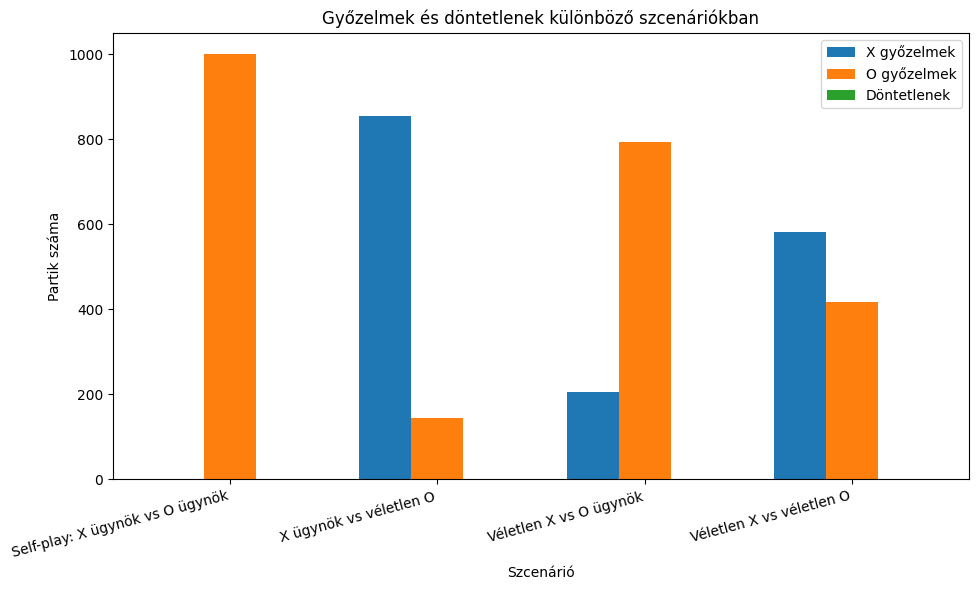

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_hu))
width = 0.25

ax.bar(x - width, df_hu["X győzelmek"], width, label="X győzelmek")
ax.bar(x,         df_hu["O győzelmek"], width, label="O győzelmek")
ax.bar(x + width, df_hu["Döntetlenek"], width, label="Döntetlenek")

ax.set_xticks(x)
ax.set_xticklabels(df_hu["Szenárió"], rotation=15, ha="right")

ax.set_ylabel("Partik száma")
ax.set_xlabel("Szcenárió")
ax.set_title("Győzelmek és döntetlenek különböző szcenáriókban")

ax.legend()
plt.tight_layout()
plt.show()


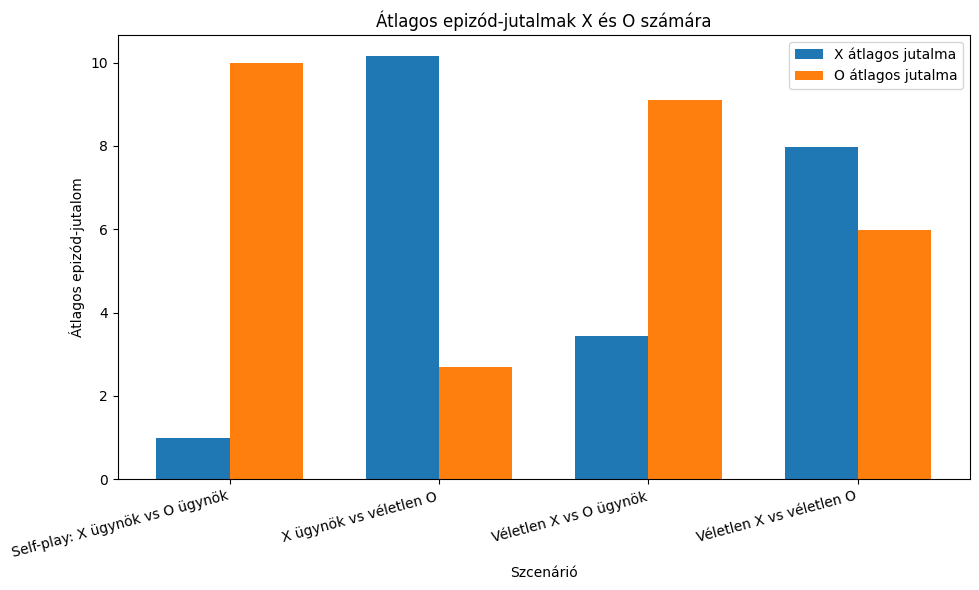

In [6]:
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_hu))
width = 0.35

ax.bar(x - width/2, df_hu["X átlagos epizód-jutalma"], width, label="X átlagos jutalma")
ax.bar(x + width/2, df_hu["O átlagos epizód-jutalma"], width, label="O átlagos jutalma")

ax.set_xticks(x)
ax.set_xticklabels(df_hu["Szenárió"], rotation=15, ha="right")

ax.set_ylabel("Átlagos epizód-jutalom")
ax.set_xlabel("Szcenárió")
ax.set_title("Átlagos epizód-jutalmak X és O számára")

ax.legend()
plt.tight_layout()
plt.show()
